(0.0, 5.1)

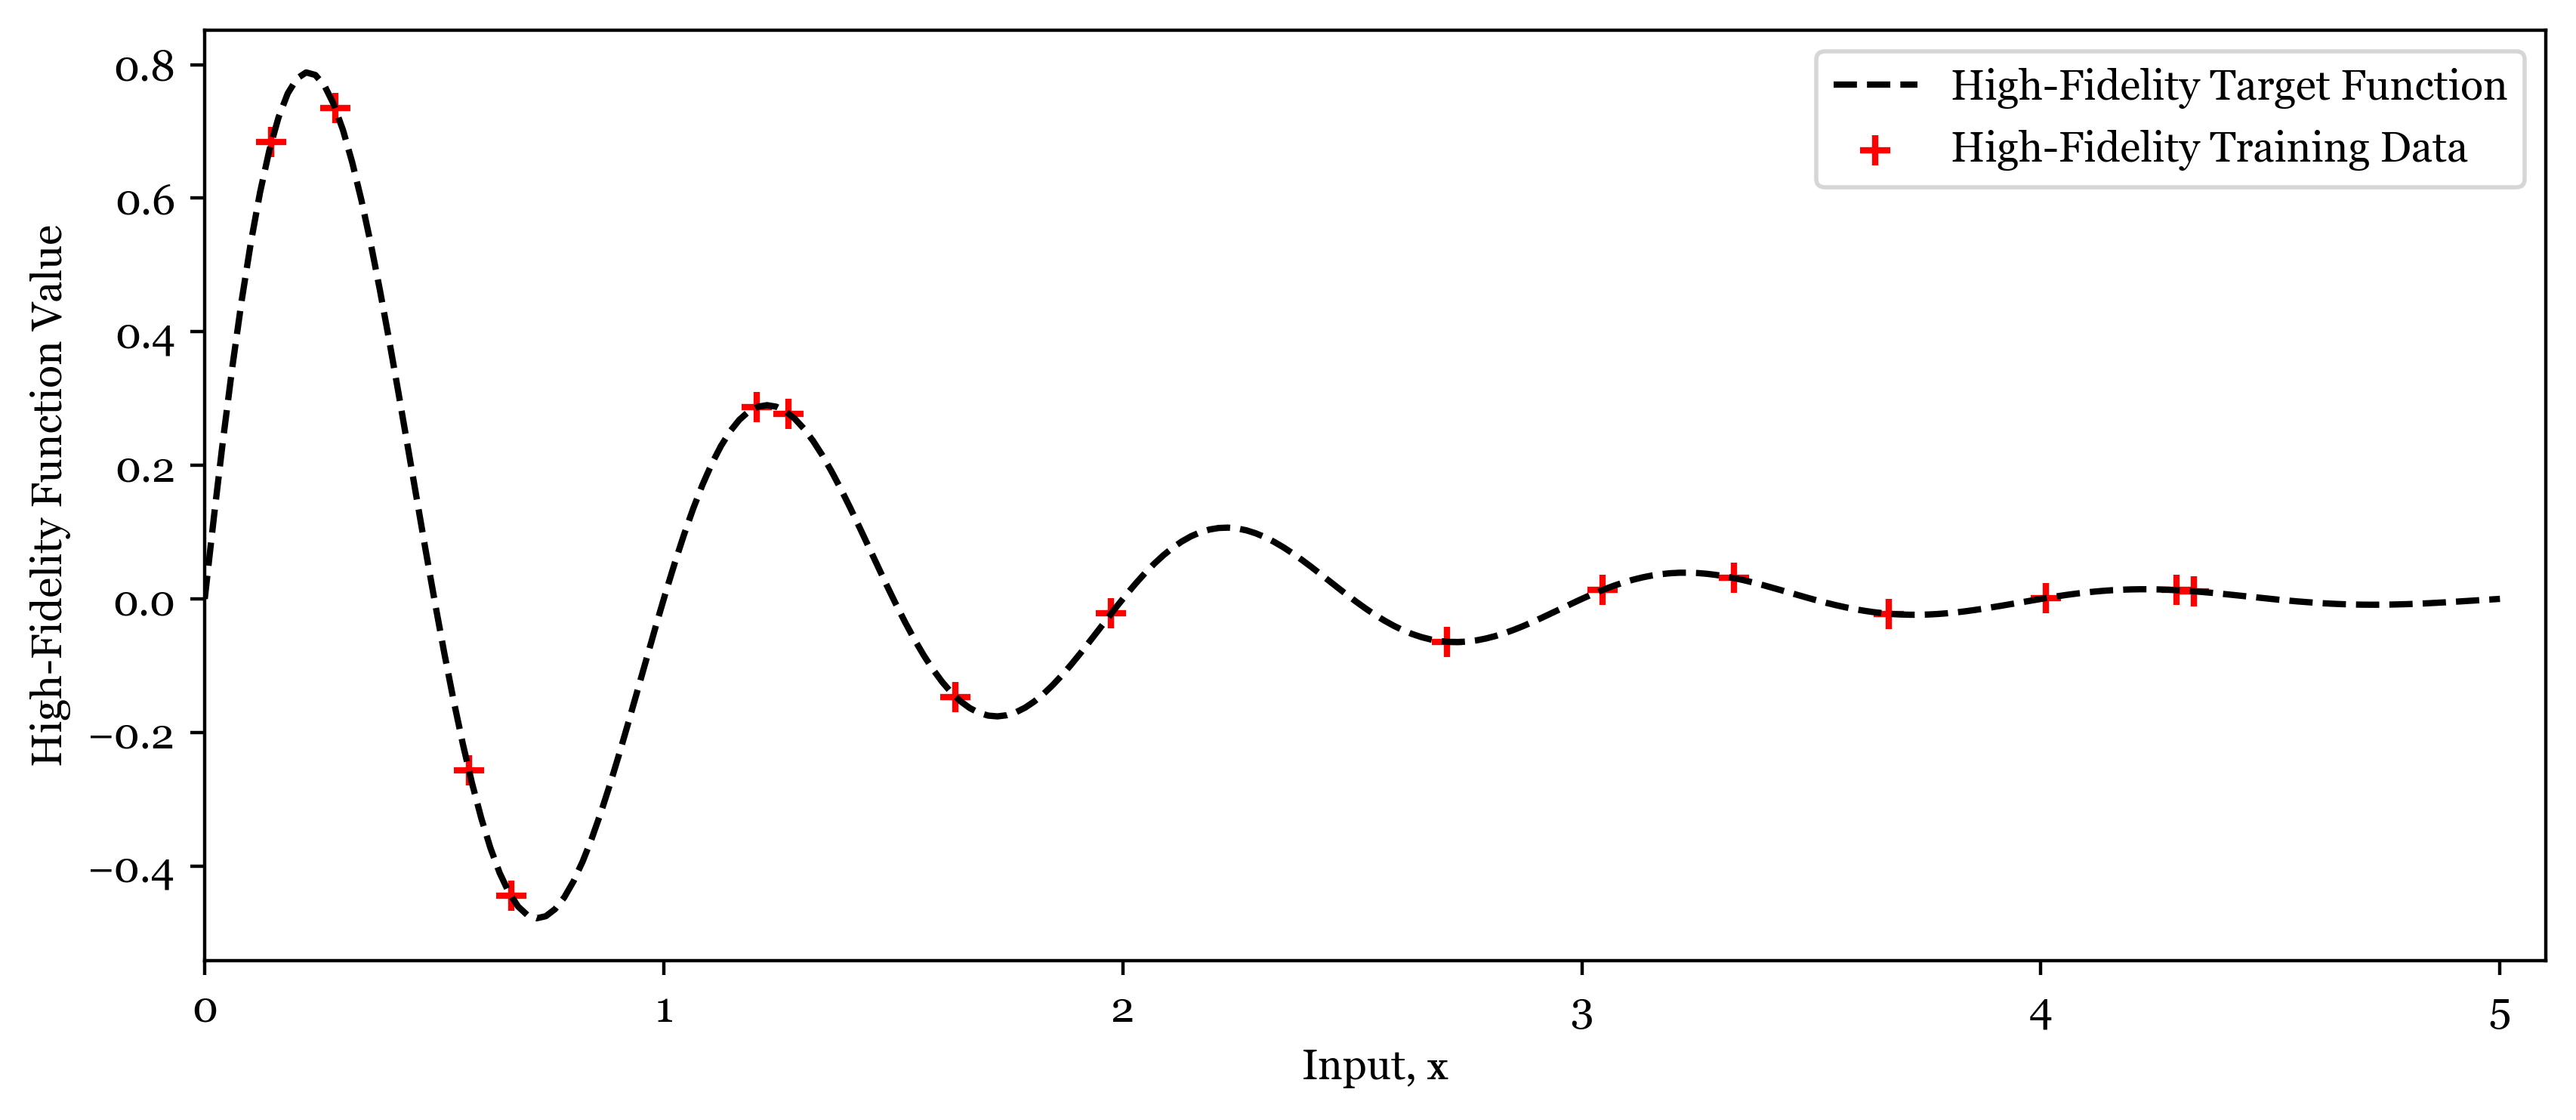

In [1]:
from mf import *  
import math 
import matplotlib.pyplot as plt 

# Plot parameters 
plt.rcParams.update({
    "font.family": "georgia",
    'text.latex.preamble': r'\\usepackage{amsmath}',
    'mathtext.fontset': 'cm',
})

# Define number of fidelity-levels 
n_fidelities = 3 

# Define a list of sample sizes
sample_sizes = [15, 100, 250]

# Define the high and low-fidelity functions
funcs = [
    lambda x: np.exp(-x) * np.sin(2*math.pi*x), 
    lambda x: np.sin(2*math.pi*x),
    lambda x: np.exp(-x)
]

# Making some testing data 
Xtest = np.linspace(0.0, 5.0, 250).reshape(-1,1)

# Loading high-fidelity data
true_data = np.hstack((Xtest, funcs[0](Xtest)))

# Selecting optimal high-fidelity data
np.random.seed(43)
cutoff = 0.0
X_hf = np.random.uniform(cutoff, 5.0, size = sample_sizes[0]).reshape(-1,1)
hf_data = np.hstack((X_hf, funcs[0](X_hf)))

# Loading medium-fidelity data 
X_mf = np.random.uniform(0.0, 5.0, size = sample_sizes[1]).reshape(-1,1)
mf_data = np.hstack((X_mf, funcs[1](X_mf)))

# Loading low-fidelity data 
X_lf = np.random.uniform(0.0, 5.0, size = sample_sizes[2]).reshape(-1,1)
lf_data = np.hstack((X_lf, funcs[2](X_lf)))

# Creating a multi-fidelity-friendly data dictionary 
data_dict = {
    2:{
        'X':hf_data[:,0].reshape(-1,1),
        'Y':hf_data[:,1],
        'noise_var':1e-6,
        'var':np.var(hf_data[:,1]),
        'cost':100.0
    },
    1:{
        'X':mf_data[:,0].reshape(-1,1),
        'Y':mf_data[:,1],
        'noise_var':1e-6,
        'var':np.var(mf_data[:,1]),
        'cost':2.0
    },
    0:{
        'X':lf_data[:,0].reshape(-1,1),
        'Y':lf_data[:,1],
        'noise_var':1e-6,
        'var':np.var(lf_data[:,1]),
        'cost':1.0
    }
}


plt.figure(figsize=(10,4),dpi = 400)
plt.plot(Xtest.ravel(), funcs[0](Xtest).ravel(), linestyle = 'dashed', color = 'black', label = 'High-Fidelity Target Function')
plt.scatter(hf_data[:,0], hf_data[:,1], s = 50, marker = '+', color = 'red', label = 'High-Fidelity Training Data')

plt.xlabel("Input, $\mathbf{x}$")
plt.ylabel("High-Fidelity Function Value")
plt.legend()
plt.xlim([0,5.1])

In [2]:
model = NARGP(
    data_dict, RBF, Linear, max_cond = 4e3, epsilon = 1e-12
)

Calibrated white noise variance: -7.3277e+00
Calibrated white noise variance: -5.7045e+00
Calibrated white noise variance: -1.3816e+01


In [3]:
model.optimize(0, max_iter = 1000, max_stepsize = 1e-2, verbose = False)

Best log-marginal likelihood: -3057.22939


In [4]:
model.optimize(1, max_iter = 1000, max_stepsize = 1e-3, verbose = False)

Best log-marginal likelihood: -903.77680


In [10]:
model.optimize(2, max_iter = int(1e4), tol = 1e-10, max_stepsize = 1e-3, verbose = False)

Best log-marginal likelihood: -16.97926


In [11]:
model.d[2]['model'].p

{'k_param': Array([-1.45318608,  3.6909288 , 11.4309721 ], dtype=float64),
 'm_param': Array([ 0.35311206, -0.08623794,  0.30937657], dtype=float64),
 'noise_var': Array(-34.04731871, dtype=float64)}

In [12]:
# model.d[2]['model'].p['noise_var'] = jnp.array(-1e5)


mu, cov = model.predict(Xtest, 2)
cov = jnp.sqrt(cov)*2

(0.0, 5.1)

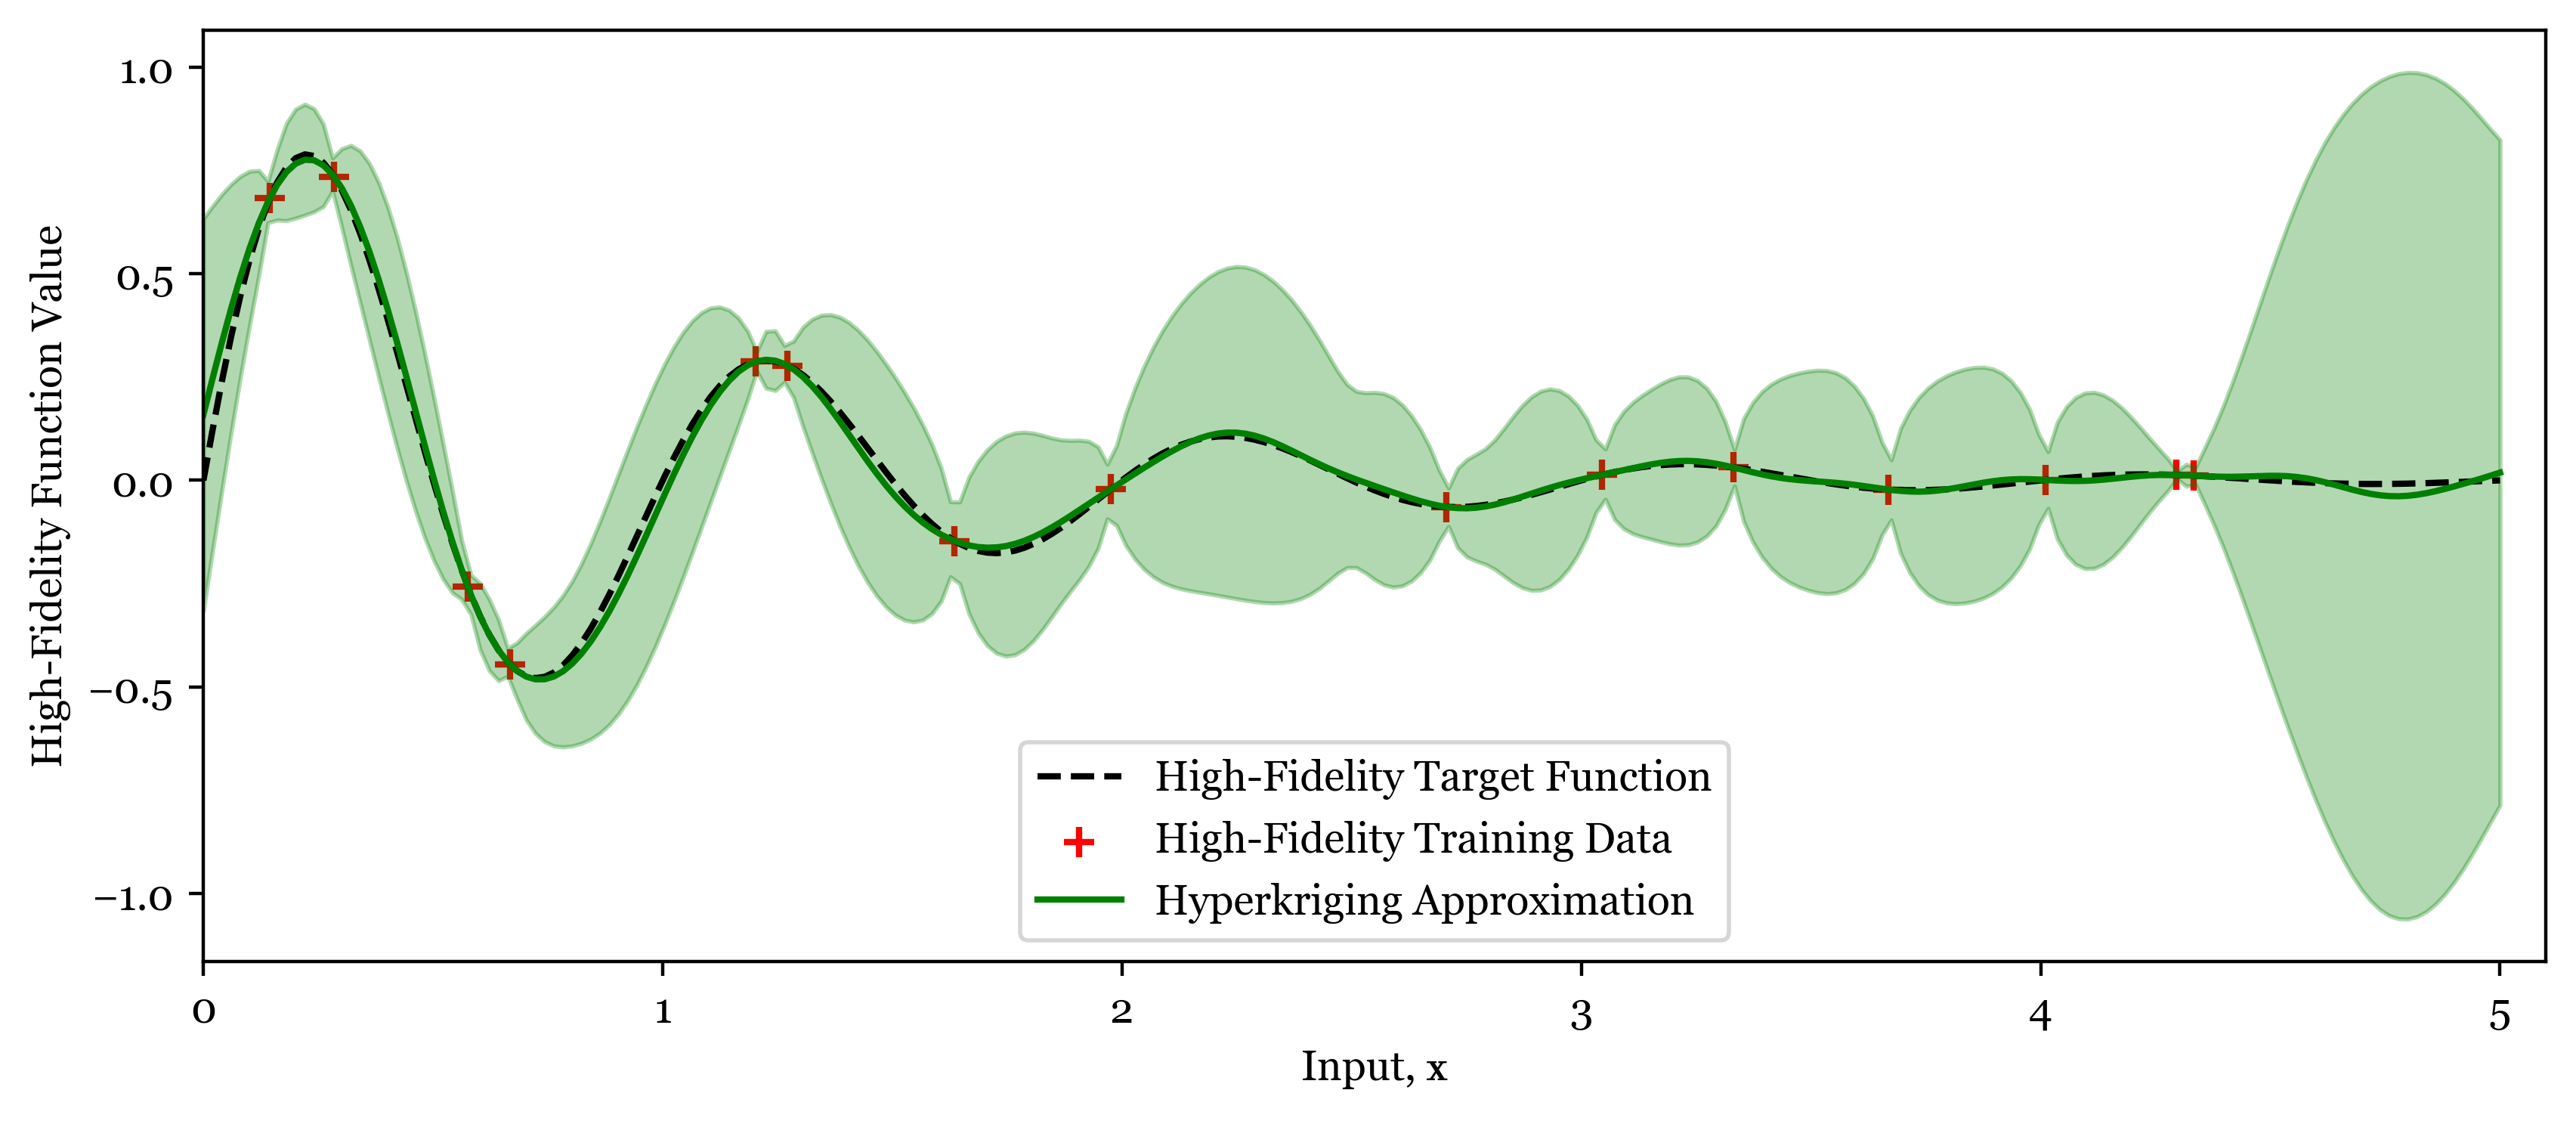

In [13]:
plt.figure(figsize=(10,4),dpi = 400)
plt.plot(Xtest.ravel(), funcs[0](Xtest).ravel(), linestyle = 'dashed', color = 'black', label = 'High-Fidelity Target Function')
plt.scatter(hf_data[:,0], hf_data[:,1], s = 50, marker = '+', color = 'red', label = 'High-Fidelity Training Data')
plt.plot(Xtest.ravel(), mu, color = 'green', label = "Hyperkriging Approximation")
plt.fill_between(Xtest.ravel(), mu -2*np.sqrt(cov), mu + 2*np.sqrt(cov), alpha = 0.3, color = 'green')

plt.xlabel("Input, $\mathbf{x}$")
plt.ylabel("High-Fidelity Function Value")
plt.legend()
plt.xlim([0,5.1])